In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *


from BaselinePrerocess import baseline_process
from cnn import CNN

import pygad
import time

### Preprocess

In [2]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9

In [3]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = baseline_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [4]:
print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 96, 16) (9634, 96, 16) (19268, 96, 16) (77069, 96) (9634, 96) (19268, 96)


### Select event

In [5]:
start_idx = 7600
end_idx = 7660
duration = end_idx - start_idx

In [6]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(60, 96)

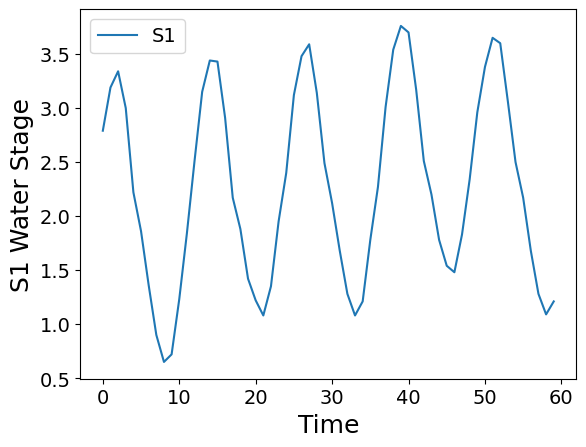

In [7]:
plt.plot(ws1[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Get optimizable and not optimizable variables

In [8]:
X = test_X_mask[start_idx:end_idx, :, :]
X_1d = np.reshape(X, -1)

print(X.shape)
print(X_1d.shape)

(60, 96, 16)
(92160,)


In [9]:
gate_state = test_X_mask[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(60, 96, 7)
(40320,)


In [10]:
not_gate1 = test_X_mask[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(60, 96, 2)


In [11]:
not_gate2 = test_X_mask[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(60, 96, 7)


### GA

In [12]:
saved_model = load_model('cnn.h5', compile=False)

In [13]:
def fitness_func(ga_instance, solution, solution_idx):
    # reshape gate to 3d
    solution = np.reshape(solution, (duration, 96, 7))
    
    # get input numpy
    input_np = np.zeros(((duration, 96, 16)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    yhat = saved_model.predict(input_np, verbose=0)
    
    y_max = 0.62
    y_min = 0.2
    
    penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty = np.abs(y_min - yhat[i, j])
                
            else:
                penalty = 0
            
            penalty_sum += penalty
    
    
    if penalty_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_sum
    return fitness

In [14]:
fitness_function = fitness_func

num_generations = 200
num_parents_mating = 8

sol_per_pop = 64
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [15]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [16]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

CPU time: 851.8577257000001 seconds


In [17]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Parameters of the best solution : [0.82827432 0.3901857  0.11949994 ... 0.94237317 0.38365993 0.23986467]
Fitness value of the best solution = 0.0005464247524539576


### Post-processing

In [19]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 16)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict(best_input)
best_perf = ws_scaler.inverse_transform(best_perf)

2/2 [==============================] - 0s 2ms/step


In [20]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

57


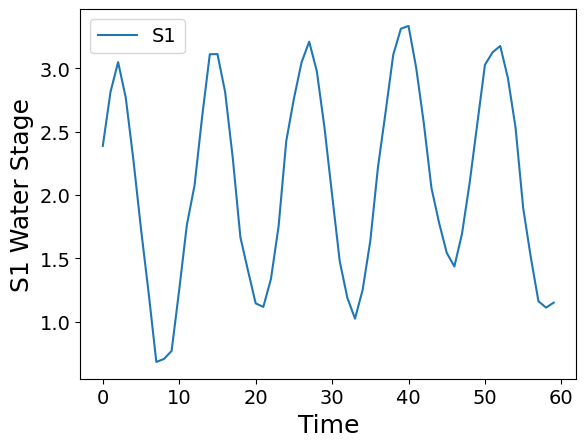

In [21]:
plt.plot(best_perf[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [22]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA results/best_gate_event1.csv", index=False)
Optimal_gate

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.828274,0.390186,0.119500,0.408073,0.643510,0.613775,0.718231,0.143309,0.723482,0.269929,...,0.608254,0.339663,0.498184,0.564822,0.676309,0.544280,0.267147,0.087015,0.164653,0.417486
1,0.872469,0.751413,0.775909,0.472391,0.070021,0.998647,0.065922,0.314724,0.921895,0.726824,...,0.923045,0.398617,0.288229,0.100317,0.559584,0.459998,0.018960,0.596150,0.222227,0.105367
2,0.529814,0.338892,0.514986,0.645990,0.124645,0.629198,0.210298,0.626776,0.314491,0.826272,...,0.529619,0.750727,0.499919,0.184394,0.357927,0.017607,0.141727,0.733188,0.647473,0.541868
3,0.577813,0.163224,0.854609,0.584278,0.637592,0.166906,0.403903,0.785428,0.344954,0.433726,...,0.594542,0.797132,0.612946,0.622350,0.617045,0.494193,0.372449,0.348393,0.569022,0.425340
4,0.610854,0.877074,0.818570,0.266842,0.892354,0.612894,0.560807,0.507031,0.979996,0.497087,...,0.658516,0.158712,0.990599,0.605657,0.729770,0.650323,0.367159,0.940239,0.517689,0.480454
5,0.242855,0.741868,0.409056,0.721095,0.620865,0.840136,0.491292,0.267829,0.278165,0.587177,...,0.599469,0.347472,0.058128,0.430968,0.893558,0.383553,0.158437,0.087068,0.739893,0.329783
6,0.893308,0.473489,0.097410,0.072276,0.776931,0.337952,0.356649,0.179488,0.184173,0.077201,...,0.850754,0.846439,0.533461,0.107682,0.370136,0.575651,0.478763,0.032868,0.993364,0.260815
7,0.653451,0.172311,0.972774,0.839441,0.786681,0.688431,0.845187,0.789568,0.426661,0.127587,...,0.375337,0.228632,0.053611,0.886964,0.375848,0.470496,0.077425,0.603225,0.412290,0.180064
8,0.482615,0.074160,0.145737,0.349673,0.265641,0.248989,0.011292,0.830423,0.034846,0.213824,...,0.076196,0.023987,0.989261,0.216519,0.472836,0.781098,0.488495,0.649102,0.459869,0.197652
9,0.655860,0.948407,0.550788,0.129680,0.921725,0.372866,0.713807,0.648730,0.113666,0.300969,...,0.492236,0.727147,0.262008,0.391574,0.858183,0.516774,0.595806,0.431494,0.688814,0.419880


In [23]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA results/best_performance_event1.csv", index=False)
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,2.388205,2.436560,2.385051,2.715778,2.882910,2.913459,2.881540,3.225767,2.952802,3.025165,...,1.375197,1.434899,1.304558,1.503248,1.470419,1.631239,1.637936,1.828816,1.703002,1.966801
1,2.811614,2.908118,2.851581,3.132646,3.027134,3.149148,3.100631,3.357974,2.795947,2.931068,...,1.548804,1.654411,1.761279,1.965842,1.882828,2.131481,2.167156,2.282337,2.263839,2.555213
2,3.048820,3.110898,3.053651,3.319657,2.941992,3.055093,2.985809,3.238443,2.402433,2.548478,...,1.957690,2.163149,2.388955,2.556203,2.464815,2.755917,2.797665,2.939211,2.832201,3.153709
3,2.768900,2.811603,2.852925,3.097776,2.428269,2.590694,2.600880,2.789662,1.956761,2.248007,...,2.317187,2.569758,2.714591,2.924689,2.783051,3.113004,2.938808,3.134339,2.993131,3.356164
4,2.277317,2.279500,2.329896,2.537668,1.850170,1.987343,2.000684,2.079384,1.334069,1.732014,...,2.758193,3.135674,3.051871,3.275928,3.048690,3.468236,3.024776,3.176527,3.022220,3.396193
5,1.729326,1.865438,1.887679,2.011592,1.345343,1.568066,1.613302,1.618348,0.916717,1.279693,...,3.093830,3.461781,3.230366,3.425523,3.245481,3.640639,3.003293,3.224343,3.042997,3.410872
6,1.225050,1.393040,1.393585,1.557208,0.819051,1.105071,1.080500,1.119611,0.534125,0.862204,...,2.996283,3.425480,2.817527,2.914800,2.876699,3.288107,2.414341,2.520597,2.474598,2.866305
7,0.683190,0.899340,0.978940,1.056146,0.506427,0.756721,0.786426,0.778935,0.567687,0.744695,...,2.905720,3.325312,2.527922,2.640139,2.574441,2.986092,2.127231,2.341790,2.260794,2.587619
8,0.706433,0.881337,1.001490,1.006304,0.850457,1.021919,1.089504,1.109023,1.208624,1.340090,...,2.647630,2.999962,2.180555,2.262179,2.289190,2.541759,1.769397,1.896238,1.931079,2.109562
9,0.770292,0.825611,0.983945,0.988394,1.087439,1.061409,1.263083,1.332254,1.520255,1.465491,...,2.315172,2.618477,1.797413,1.978651,1.935130,2.167519,1.393873,1.615513,1.575726,1.732947
